# 🎯 Face Recognition: YOLOv8 + ViT Training

Notebook lengkap untuk:
1. **Exploratory Data Analysis (EDA)**
2. **Data Preprocessing**
3. **Training ViT Classifier**
4. **Inference dengan YOLOv8-face + ViT**

## Architecture
```
Image → YOLOv8-face (Detection) → Crop Face → ViT (Classification) → Result
```

---
# Part 1: Setup & Installation
---

In [1]:
# Install dependencies
!pip install ultralytics torch torchvision transformers opencv-python pillow matplotlib seaborn scikit-learn huggingface_hub tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from pathlib import Path
import cv2
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

c:\Users\MAHARDIKA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🖥️ Device: cuda
   GPU: NVIDIA GeForce RTX 5060 Ti
   Memory: 17.1 GB


---
# Part 2: Exploratory Data Analysis (EDA)
---

In [3]:
# Dataset path - sesuaikan dengan lokasi dataset kamu
DATASET_PATH = "../cropped_faces"  # Folder dengan subfolder per class

# Alternative: jika dataset belum di-crop, gunakan path ke dataset original
# DATASET_PATH = "../Computing_project-2/train"

print(f"📁 Dataset path: {DATASET_PATH}")
print(f"   Exists: {os.path.exists(DATASET_PATH)}")

📁 Dataset path: ../cropped_faces
   Exists: True


In [4]:
def analyze_dataset(dataset_path):
    """Analyze dataset structure and statistics"""
    
    if not os.path.exists(dataset_path):
        print(f"❌ Dataset not found at {dataset_path}")
        return None
    
    # Get all classes (subfolders)
    classes = sorted([d for d in os.listdir(dataset_path) 
                     if os.path.isdir(os.path.join(dataset_path, d))])
    
    print(f"\n📊 DATASET ANALYSIS")
    print("=" * 50)
    print(f"Classes found: {len(classes)}")
    print(f"Class names: {classes}")
    
    # Count images per class
    class_counts = {}
    image_sizes = []
    image_extensions = Counter()
    
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(cls_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        class_counts[cls] = len(images)
        
        # Sample some images for size analysis
        for img_name in images[:10]:
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                image_sizes.append(img.size)
                ext = os.path.splitext(img_name)[1].lower()
                image_extensions[ext] += 1
            except:
                pass
    
    # Print statistics
    total_images = sum(class_counts.values())
    print(f"\nTotal images: {total_images}")
    print(f"\nImages per class:")
    for cls, count in sorted(class_counts.items(), key=lambda x: -x[1]):
        bar = "█" * int(count / max(class_counts.values()) * 30)
        print(f"  {cls:15} : {count:4} {bar}")
    
    # Image size statistics
    if image_sizes:
        widths = [s[0] for s in image_sizes]
        heights = [s[1] for s in image_sizes]
        print(f"\nImage dimensions:")
        print(f"  Width  - Min: {min(widths)}, Max: {max(widths)}, Avg: {np.mean(widths):.0f}")
        print(f"  Height - Min: {min(heights)}, Max: {max(heights)}, Avg: {np.mean(heights):.0f}")
    
    print(f"\nFile extensions: {dict(image_extensions)}")
    
    return {
        'classes': classes,
        'class_counts': class_counts,
        'total_images': total_images,
        'image_sizes': image_sizes
    }

# Run analysis
dataset_info = analyze_dataset(DATASET_PATH)


📊 DATASET ANALYSIS
Classes found: 9
Class names: ['akbar', 'aprilianza', 'bian', 'fadhilah', 'falah', 'iksan', 'imelda', 'rifqy', 'yolanda']

Total images: 2085

Images per class:
  falah           :  332 ██████████████████████████████
  fadhilah        :  296 ██████████████████████████
  iksan           :  296 ██████████████████████████
  akbar           :  293 ██████████████████████████
  aprilianza      :  293 ██████████████████████████
  rifqy           :  175 ███████████████
  imelda          :  165 ██████████████
  yolanda         :  119 ██████████
  bian            :  116 ██████████

Image dimensions:
  Width  - Min: 28, Max: 380, Avg: 194
  Height - Min: 32, Max: 505, Avg: 258

File extensions: {'.jpg': 90}


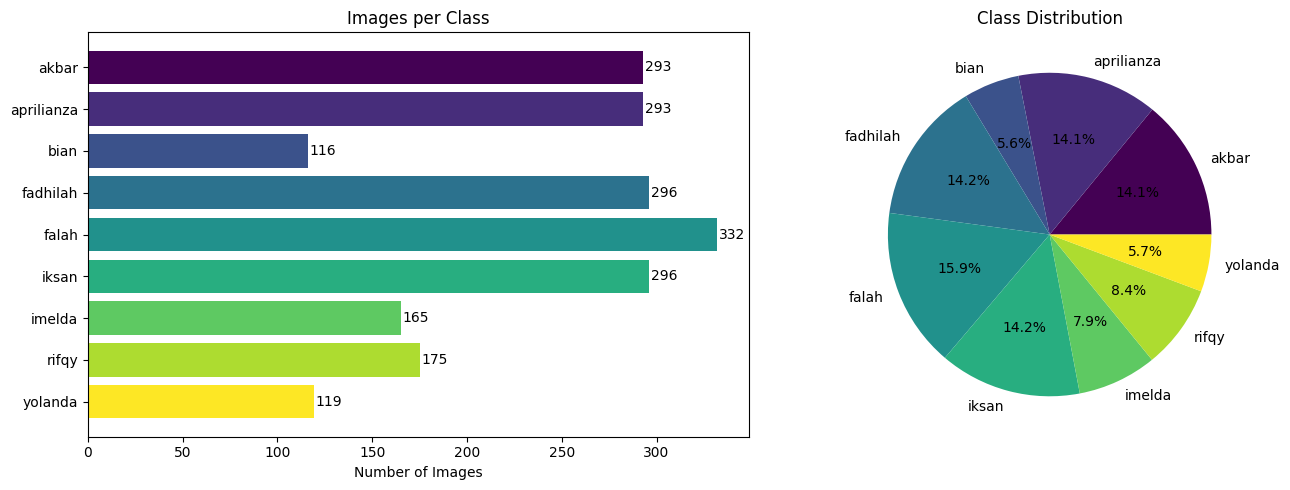


📈 Saved: class_distribution.png


In [5]:
# Visualize class distribution
if dataset_info:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    classes = list(dataset_info['class_counts'].keys())
    counts = list(dataset_info['class_counts'].values())
    colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
    
    axes[0].barh(classes, counts, color=colors)
    axes[0].set_xlabel('Number of Images')
    axes[0].set_title('Images per Class')
    axes[0].invert_yaxis()
    
    for i, (cls, count) in enumerate(zip(classes, counts)):
        axes[0].text(count + 1, i, str(count), va='center')
    
    # Pie chart
    axes[1].pie(counts, labels=classes, autopct='%1.1f%%', colors=colors)
    axes[1].set_title('Class Distribution')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📈 Saved: class_distribution.png")

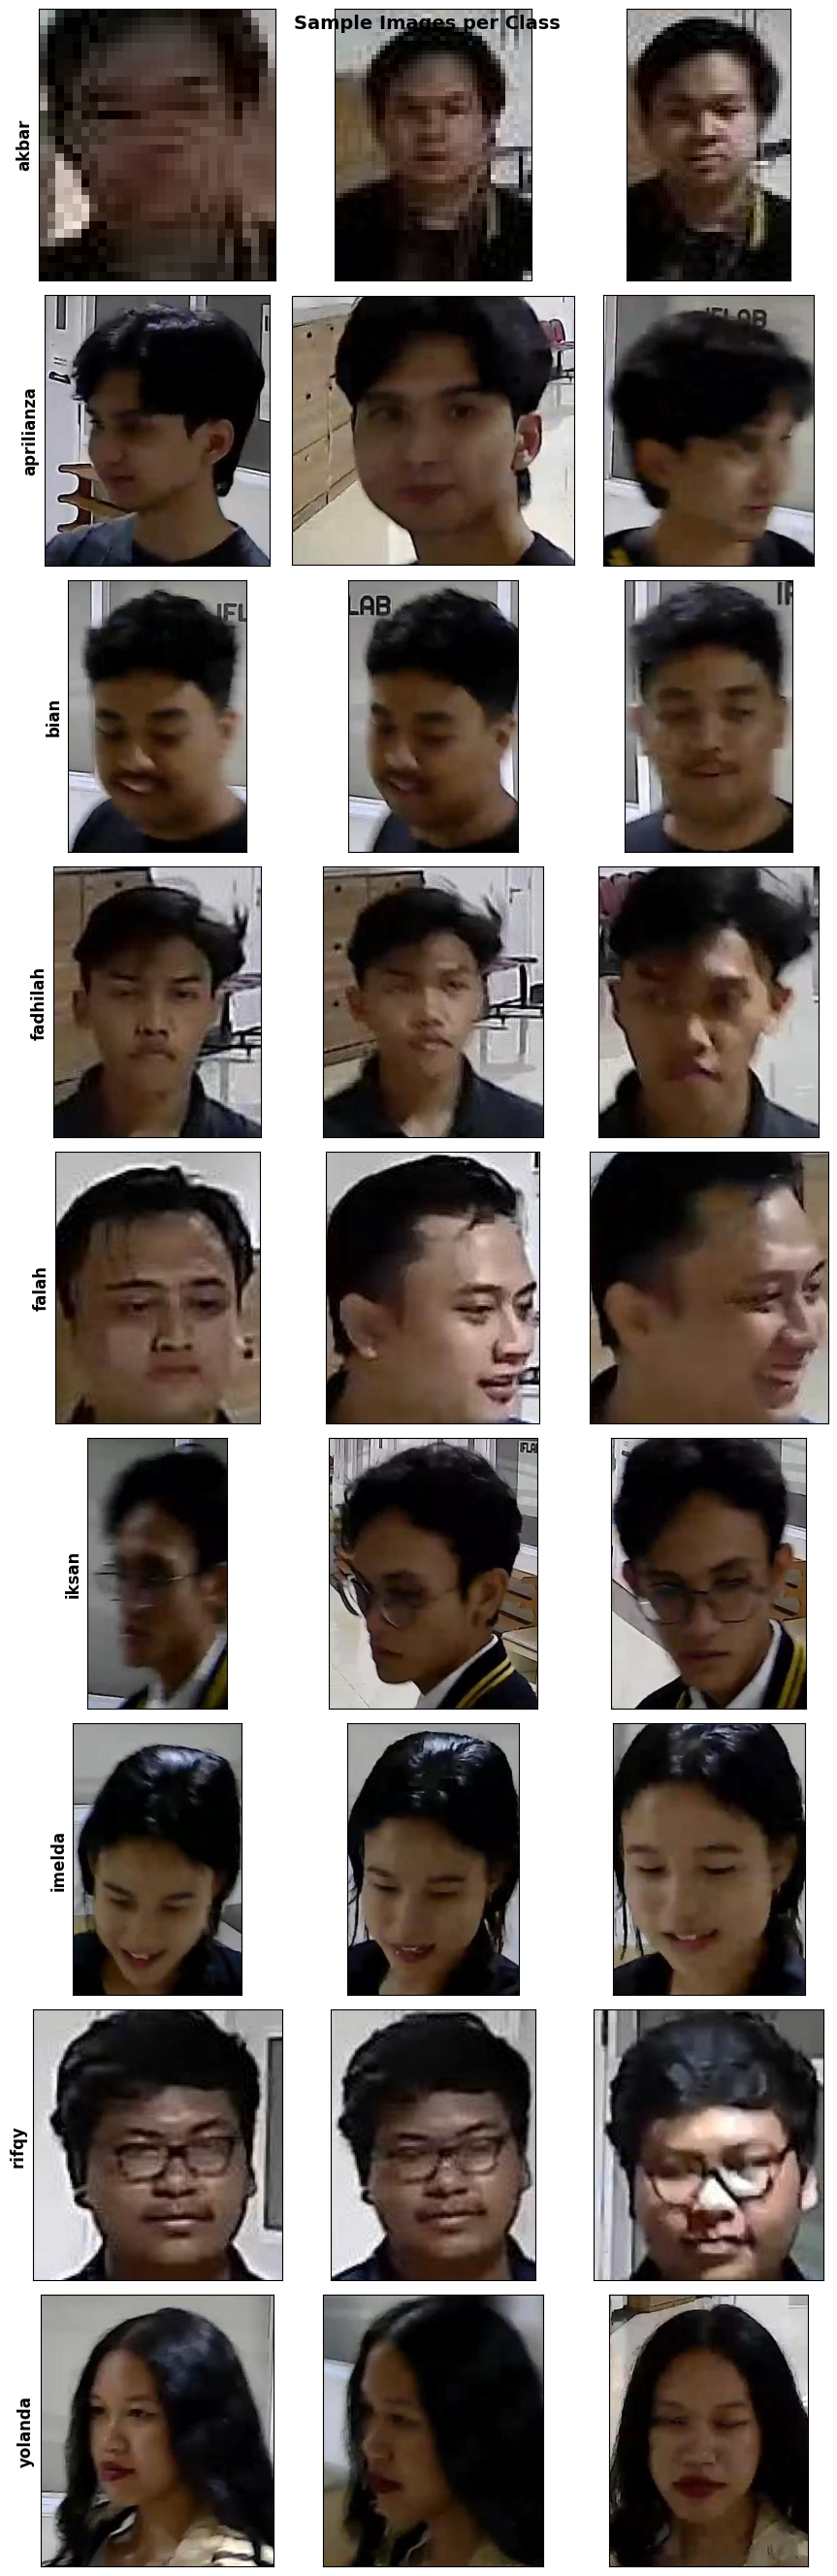


📸 Saved: sample_images.png


In [6]:
# Visualize sample images from each class
def show_sample_images(dataset_path, classes, samples_per_class=3):
    """Display sample images from each class"""
    
    n_classes = len(classes)
    fig, axes = plt.subplots(n_classes, samples_per_class, 
                             figsize=(samples_per_class * 3, n_classes * 3))
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(cls_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:samples_per_class]
        
        for j in range(samples_per_class):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            
            if j < len(images):
                img_path = os.path.join(cls_path, images[j])
                img = Image.open(img_path)
                ax.imshow(img)
                if j == 0:
                    ax.set_ylabel(cls, fontsize=12, fontweight='bold')
            
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.suptitle('Sample Images per Class', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📸 Saved: sample_images.png")

if dataset_info:
    show_sample_images(DATASET_PATH, dataset_info['classes'])

In [7]:
# Check for class imbalance
if dataset_info:
    counts = list(dataset_info['class_counts'].values())
    
    imbalance_ratio = max(counts) / min(counts)
    std_dev = np.std(counts)
    
    print("\n⚖️ CLASS BALANCE ANALYSIS")
    print("=" * 50)
    print(f"Min samples: {min(counts)}")
    print(f"Max samples: {max(counts)}")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}x")
    print(f"Standard deviation: {std_dev:.1f}")
    
    if imbalance_ratio > 3:
        print("\n⚠️ WARNING: Significant class imbalance detected!")
        print("   Consider: data augmentation, oversampling, or class weights")
    else:
        print("\n✅ Dataset is relatively balanced")


⚖️ CLASS BALANCE ANALYSIS
Min samples: 116
Max samples: 332
Imbalance ratio: 2.86x
Standard deviation: 81.4

✅ Dataset is relatively balanced


---
# Part 3: Data Preparation
---

In [8]:
# Configuration
CONFIG = {
    'image_size': 224,
    'batch_size': 16,
    'num_epochs': 10,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'train_split': 0.8,
    'random_seed': 42
}

print("⚙️ Training Configuration:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

⚙️ Training Configuration:
   image_size: 224
   batch_size: 16
   num_epochs: 10
   learning_rate: 2e-05
   weight_decay: 0.01
   train_split: 0.8
   random_seed: 42


In [9]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

print("✅ Transforms defined")
print("\nTrain augmentations:")
print("  - Random horizontal flip")
print("  - Random rotation (±15°)")
print("  - Color jitter")
print("  - Random translation")

✅ Transforms defined

Train augmentations:
  - Random horizontal flip
  - Random rotation (±15°)
  - Color jitter
  - Random translation


In [10]:
# Load dataset
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)

# Get class names
class_names = full_dataset.classes
num_classes = len(class_names)

print(f"\n📦 Dataset loaded")
print(f"   Total samples: {len(full_dataset)}")
print(f"   Number of classes: {num_classes}")
print(f"   Classes: {class_names}")


📦 Dataset loaded
   Total samples: 2085
   Number of classes: 9
   Classes: ['akbar', 'aprilianza', 'bian', 'fadhilah', 'falah', 'iksan', 'imelda', 'rifqy', 'yolanda']


In [11]:
# Split dataset
torch.manual_seed(CONFIG['random_seed'])

train_size = int(CONFIG['train_split'] * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transform to val_dataset
val_dataset.dataset.transform = val_transform

print(f"\n📊 Dataset split:")
print(f"   Training: {len(train_dataset)} samples ({CONFIG['train_split']*100:.0f}%)")
print(f"   Validation: {len(val_dataset)} samples ({(1-CONFIG['train_split'])*100:.0f}%)")


📊 Dataset split:
   Training: 1668 samples (80%)
   Validation: 417 samples (20%)


In [12]:
# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✅ DataLoaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")


✅ DataLoaders created
   Train batches: 105
   Val batches: 27


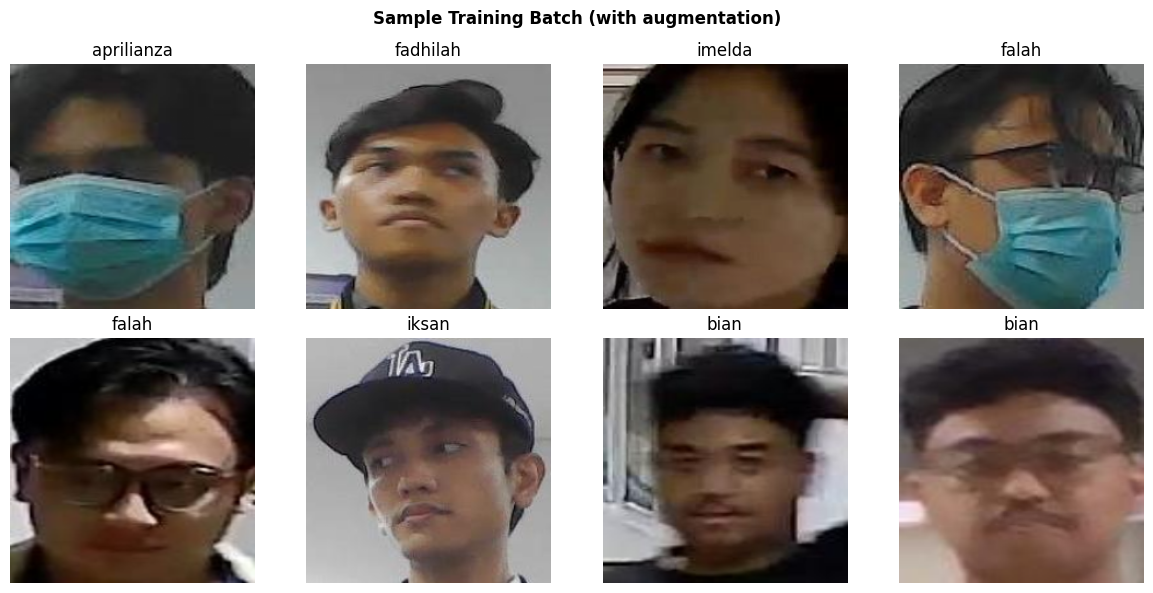

In [13]:
# Visualize a batch
def show_batch(dataloader, class_names):
    """Visualize a batch of images"""
    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Denormalize
            img = images[i].numpy().transpose(1, 2, 0)
            img = img * 0.5 + 0.5  # Denormalize
            img = np.clip(img, 0, 1)
            
            ax.imshow(img)
            ax.set_title(class_names[labels[i]])
        ax.axis('off')
    
    plt.suptitle('Sample Training Batch (with augmentation)', fontweight='bold')
    plt.tight_layout()
    plt.show()

show_batch(train_loader, class_names)

---
# Part 4: Download YOLOv8-face Model
---

In [14]:
from huggingface_hub import hf_hub_download

# Download YOLOv8-face model
YOLO_MODEL_PATH = "yolov8-face.pt"

if not os.path.exists(YOLO_MODEL_PATH):
    print("📥 Downloading YOLOv8-face model...")
    model_path = hf_hub_download(
        repo_id="arnabdhar/YOLOv8-Face-Detection", 
        filename="model.pt",
        local_dir="."
    )
    os.rename("model.pt", YOLO_MODEL_PATH)
    print(f"✅ Model saved as: {YOLO_MODEL_PATH}")
else:
    print(f"✅ YOLOv8-face model already exists: {YOLO_MODEL_PATH}")

✅ YOLOv8-face model already exists: yolov8-face.pt


In [15]:
# Load and test YOLOv8-face
from ultralytics import YOLO

yolo = YOLO(YOLO_MODEL_PATH)
print("✅ YOLOv8-face loaded")

# Warm up
_ = yolo.predict(np.zeros((320, 320, 3), dtype=np.uint8), verbose=False)
print("✅ YOLOv8 warmed up")

✅ YOLOv8-face loaded
✅ YOLOv8 warmed up


---
# Part 5: Build & Train ViT Model
---

In [16]:
# Load ViT model
print("📥 Loading ViT model...")

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

model.to(device)
print(f"✅ ViT model loaded on {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

📥 Loading ViT model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ ViT model loaded on cuda
   Parameters: 85,805,577
   Trainable: 85,805,577


In [17]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=CONFIG['num_epochs'],
    eta_min=1e-7
)

print("✅ Optimizer and scheduler configured")

✅ Optimizer and scheduler configured


In [18]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return running_loss / len(dataloader), correct / total


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / len(dataloader), correct / total, all_preds, all_labels

In [19]:
# Training loop
print("\n" + "=" * 60)
print("🚀 STARTING TRAINING")
print("=" * 60)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
best_model_path = "best_vit_yolo.pth"

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    print(f"LR: {scheduler.get_last_lr()[0]:.2e}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"💾 New best model saved! (Val Acc: {val_acc*100:.2f}%)")

print("\n" + "=" * 60)
print(f"✅ Training complete!")
print(f"   Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"   Model saved to: {best_model_path}")


🚀 STARTING TRAINING

Epoch 1/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 11.84it/s]


Train Loss: 1.6216 | Train Acc: 70.32%
Val Loss: 1.0791 | Val Acc: 95.44%
LR: 1.95e-05
💾 New best model saved! (Val Acc: 95.44%)

Epoch 2/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.46it/s]


Train Loss: 0.7077 | Train Acc: 98.92%
Val Loss: 0.5252 | Val Acc: 99.28%
LR: 1.81e-05
💾 New best model saved! (Val Acc: 99.28%)

Epoch 3/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.04it/s]


Train Loss: 0.3729 | Train Acc: 99.88%
Val Loss: 0.3297 | Val Acc: 99.76%
LR: 1.59e-05
💾 New best model saved! (Val Acc: 99.76%)

Epoch 4/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.46it/s]


Train Loss: 0.2534 | Train Acc: 99.94%
Val Loss: 0.2518 | Val Acc: 100.00%
LR: 1.31e-05
💾 New best model saved! (Val Acc: 100.00%)

Epoch 5/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.29it/s]


Train Loss: 0.1994 | Train Acc: 99.94%
Val Loss: 0.2085 | Val Acc: 99.76%
LR: 1.01e-05

Epoch 6/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.43it/s]


Train Loss: 0.1701 | Train Acc: 100.00%
Val Loss: 0.1849 | Val Acc: 99.76%
LR: 6.98e-06

Epoch 7/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]


Train Loss: 0.1531 | Train Acc: 100.00%
Val Loss: 0.1713 | Val Acc: 99.76%
LR: 4.20e-06

Epoch 8/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.01it/s]


Train Loss: 0.1434 | Train Acc: 100.00%
Val Loss: 0.1628 | Val Acc: 99.76%
LR: 2.00e-06

Epoch 9/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.36it/s]


Train Loss: 0.1385 | Train Acc: 100.00%
Val Loss: 0.1592 | Val Acc: 99.76%
LR: 5.87e-07

Epoch 10/10
----------------------------------------


Validating: 100%|██████████| 27/27 [00:02<00:00, 12.28it/s]

Train Loss: 0.1361 | Train Acc: 100.00%
Val Loss: 0.1581 | Val Acc: 99.76%
LR: 1.00e-07

✅ Training complete!
   Best validation accuracy: 100.00%
   Model saved to: best_vit_yolo.pth


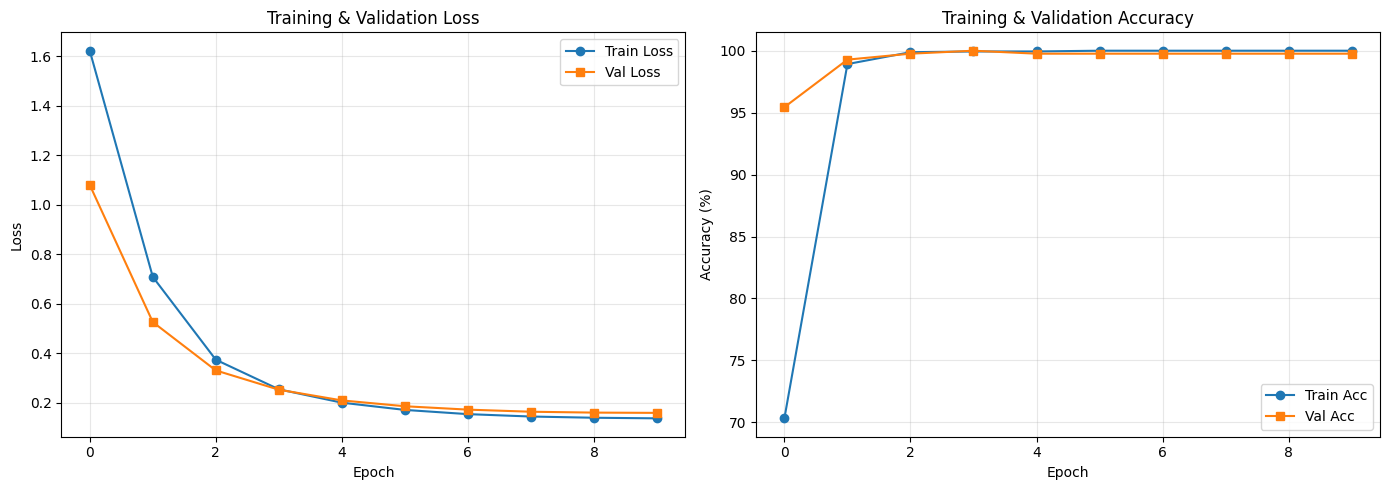


📈 Saved: training_history.png


In [20]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot([a*100 for a in history['train_acc']], label='Train Acc', marker='o')
axes[1].plot([a*100 for a in history['val_acc']], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📈 Saved: training_history.png")

---
# Part 6: Evaluation
---

In [21]:
# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f"✅ Loaded best model from {best_model_path}")

✅ Loaded best model from best_vit_yolo.pth


In [22]:
# Final evaluation
val_loss, val_acc, all_preds, all_labels = validate(model, val_loader, criterion, device)

print(f"\n📊 FINAL EVALUATION")
print("=" * 50)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

Validating: 100%|██████████| 27/27 [00:02<00:00, 12.00it/s]


📊 FINAL EVALUATION
Validation Accuracy: 100.00%
Validation Loss: 0.2518


In [23]:
# Classification report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


📋 Classification Report:
              precision    recall  f1-score   support

       akbar       1.00      1.00      1.00        49
  aprilianza       1.00      1.00      1.00        62
        bian       1.00      1.00      1.00        28
    fadhilah       1.00      1.00      1.00        62
       falah       1.00      1.00      1.00        69
       iksan       1.00      1.00      1.00        57
      imelda       1.00      1.00      1.00        34
       rifqy       1.00      1.00      1.00        35
     yolanda       1.00      1.00      1.00        21

    accuracy                           1.00       417
   macro avg       1.00      1.00      1.00       417
weighted avg       1.00      1.00      1.00       417



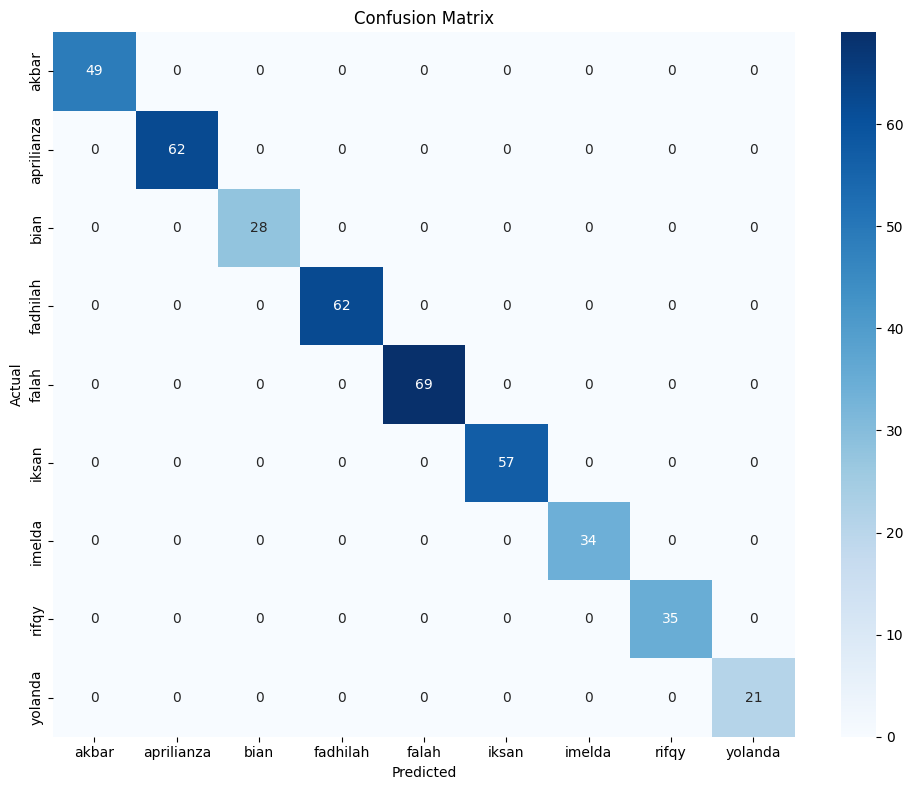


📊 Saved: confusion_matrix.png


In [24]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Saved: confusion_matrix.png")

---
# Part 7: Inference with YOLOv8 + ViT
---

In [25]:
# Role mapping for authorization
ROLE_MAPPING = {
    "iksan": "Aslab",
    "akbar": "Aslab",
    "aprilianza": "Aslab",
    "bian": "Dosen",
    "fadhilah": "Aslab",
    "falah": "Aslab",
    "imelda": "Aslab",
    "rifqy": "Aslab",
    "yolanda": "Aslab",
}

CONFIDENCE_THRESHOLD = 0.5

def get_full_label(name):
    """Get full label with role"""
    name_lower = name.lower()
    if name_lower in ROLE_MAPPING:
        role = ROLE_MAPPING[name_lower]
        return f"{name.capitalize()} ({role})", role, True
    return f"{name} (Guest)", "Guest", False

In [26]:
def detect_and_classify(image):
    """
    Full pipeline: YOLOv8 detection + ViT classification
    """
    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    pil_image = Image.fromarray(image) if isinstance(image, np.ndarray) else image
    img_np = np.array(pil_image)
    
    # YOLOv8 face detection
    results = yolo.predict(img_np, verbose=False, conf=0.35, imgsz=480)
    
    detections = []
    
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            det_conf = float(box.conf[0])
            
            # Add padding
            w, h = x2 - x1, y2 - y1
            pad = int(max(w, h) * 0.15)
            x1 = max(0, x1 - pad)
            y1 = max(0, y1 - pad)
            x2 = min(img_np.shape[1], x2 + pad)
            y2 = min(img_np.shape[0], y2 + pad)
            
            # Crop and classify
            face = pil_image.crop((x1, y1, x2, y2))
            face_tensor = val_transform(face).unsqueeze(0).to(device)
            
            with torch.no_grad():
                outputs = model(face_tensor).logits
                probs = torch.softmax(outputs, dim=1)
                confidence, predicted = torch.max(probs, 1)
            
            conf = confidence.item()
            
            if conf >= CONFIDENCE_THRESHOLD:
                name = class_names[predicted.item()]
                full_label, role, authorized = get_full_label(name)
            else:
                name = "Unknown"
                full_label = "Unknown (Guest)"
                role = "Guest"
                authorized = False
            
            detections.append({
                'bbox': (x1, y1, x2, y2),
                'name': name,
                'full_label': full_label,
                'role': role,
                'authorized': authorized,
                'confidence': conf,
                'detection_score': det_conf
            })
    
    return detections

In [27]:
def visualize_detection(image_path):
    """Visualize detection on image"""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    start = time.time()
    detections = detect_and_classify(img_rgb)
    elapsed = time.time() - start
    
    # Draw
    for d in detections:
        x1, y1, x2, y2 = d['bbox']
        color = (0, 255, 0) if d['authorized'] else (255, 0, 0)
        
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
        label = f"{d['full_label']} ({d['confidence']*100:.1f}%)"
        cv2.putText(img_rgb, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title(f"Detected {len(detections)} face(s) in {elapsed*1000:.1f}ms ({1/elapsed:.1f} FPS)")
    plt.axis('off')
    plt.show()
    
    return detections

# Test (uncomment and change path)
# visualize_detection("test_image.jpg")

---
# Part 10: Webcam Inference Check
---
Test real-time inference dengan webcam untuk memastikan model bekerja dengan baik.

In [ ]:
"""
============================================================
CELL: WEBCAM INFERENCE - JUPYTER NOTEBOOK SAFE VERSION
============================================================
DIJALANKAN DI NOTEBOOK TANPA cv2.imshow()
============================================================
"""

import cv2
import torch
import os
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np

print("=" * 60)
print("         WEBCAM INFERENCE - YOLOv8 + ViT (Notebook Safe)")
print("=" * 60)
print("Press Stop Button (kernel) to stop webcam loop")
print("=" * 60)


def process_webcam_frame_yolo(frame):
    """Process single frame: detect faces with YOLOv8 and classify with ViT"""
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)
    img_np = np.array(pil_image)
    
    # YOLOv8 face detection
    yolo_results = yolo.predict(img_np, verbose=False, conf=0.35, imgsz=480)
    
    results = []
    
    for r in yolo_results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            det_conf = float(box.conf[0])
            
            # Add padding
            w, h = x2 - x1, y2 - y1
            pad = int(max(w, h) * 0.15)
            x1 = max(0, x1 - pad)
            y1 = max(0, y1 - pad)
            x2 = min(pil_image.size[0], x2 + pad)
            y2 = min(pil_image.size[1], y2 + pad)
            
            # Crop face and classify with ViT
            face = pil_image.crop((x1, y1, x2, y2))
            face_tensor = val_transform(face).unsqueeze(0).to(device)
            
            with torch.no_grad():
                outputs = model(face_tensor).logits
                probs_cls = torch.softmax(outputs, 1)
                confidence, predicted = torch.max(probs_cls, 1)
            
            confidence = confidence.item()
            
            if confidence >= CONFIDENCE_THRESHOLD:
                name = class_names[predicted.item()]
                full_label, role, authorized = get_full_label(name)
            else:
                name = "Unknown"
                full_label = "Unknown (Guest)"
                role = "Guest"
                authorized = False
            
            color = (0, 255, 0) if authorized else (255, 0, 0)
            
            # Draw bounding box & labels
            cv2.rectangle(rgb_frame, (x1, y1), (x2, y2), color, 2)
            
            label_text = f"{full_label} ({confidence*100:.1f}%)"
            
            # Background for text
            (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(rgb_frame, (x1, y1-25), (x1+tw+10, y1), color, -1)
            cv2.putText(rgb_frame, label_text, (x1+5, y1-7),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            
            results.append({
                "name": full_label,
                "confidence": confidence,
                "authorized": authorized,
                "detection_score": det_conf
            })
    
    return rgb_frame, results


# Open webcam
cap = cv2.VideoCapture(0)
cap.set(3, 1280)
cap.set(4, 720)

if not cap.isOpened():
    print("Error: Webcam tidak terbuka")
else:
    print("Webcam opened successfully!")
    print("Loop akan berjalan sampai kamu menekan STOP (interrupt kernel).")
    
    frame_count = 0
    start_time = datetime.now()
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            processed_frame, results = process_webcam_frame_yolo(frame)
            
            frame_count += 1
            elapsed = (datetime.now() - start_time).total_seconds()
            fps = frame_count / elapsed if elapsed > 0 else 0
            
            # Draw FPS and info
            info_text = f"FPS: {fps:.1f} | Faces: {len(results)} | Backend: YOLOv8+ViT"
            cv2.putText(processed_frame, info_text,
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
            
            # Display on Jupyter cell
            clear_output(wait=True)
            plt.figure(figsize=(14, 8))
            plt.imshow(processed_frame)
            plt.axis("off")
            plt.title(f"YOLOv8 + ViT Face Recognition | {info_text}")
            plt.show()
            
    except KeyboardInterrupt:
        print("\nStopped by user")

cap.release()
print("\nWebcam Stop.")
print(f"Total frames: {frame_count}")
print(f"Average FPS: {frame_count / elapsed:.1f}" if elapsed > 0 else "")


📊 INFERENCE CHECK RESULTS
   Total frames processed: 50
   Average FPS: 41.1
   Min FPS: 14.6
   Max FPS: 85.9
   Std FPS: 10.85

   Total faces detected: 47
   Avg faces per frame: 0.94
✅ Performance: EXCELLENT (>= 20 FPS)


In [31]:
# ============================================================
# WEBCAM LIVE VIEW (OpenCV Window)
# ============================================================
# Untuk live view yang lebih smooth dengan OpenCV window
# Jalankan cell ini jika ingin melihat webcam secara real-time

def webcam_live_view(duration=30):
    """
    Live webcam view dengan OpenCV window
    
    Args:
        duration: Durasi dalam detik (0 = infinite, tekan 'q' untuk stop)
    """
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Tidak bisa membuka webcam!")
        return
    
    # Set resolution
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    print("🎥 Live Webcam View")
    print("=" * 50)
    print("   Tekan 'q' untuk keluar")
    print("   Tekan 's' untuk screenshot")
    print("=" * 50)
    
    fps_list = []
    start_time = time.time()
    screenshot_count = 0
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            t_start = time.time()
            
            # Convert and detect
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            detections = detect_and_classify(rgb_frame)
            
            t_end = time.time()
            fps = 1.0 / (t_end - t_start) if (t_end - t_start) > 0 else 0
            fps_list.append(fps)
            
            # Draw results
            for d in detections:
                x1, y1, x2, y2 = d['bbox']
                color = (0, 255, 0) if d['authorized'] else (0, 0, 255)  # BGR for OpenCV
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                
                label = f"{d['full_label']} ({d['confidence']*100:.1f}%)"
                
                # Background for text
                (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(frame, (x1, y1-25), (x1+tw+10, y1), color, -1)
                cv2.putText(frame, label, (x1+5, y1-7), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
            
            # Add info overlay
            avg_fps = np.mean(fps_list[-30:]) if fps_list else 0
            elapsed = time.time() - start_time
            
            info_text = [
                f"FPS: {avg_fps:.1f}",
                f"Faces: {len(detections)}",
                f"Time: {elapsed:.1f}s",
                f"Backend: YOLOv8 + ViT"
            ]
            
            for i, text in enumerate(info_text):
                cv2.putText(frame, text, (10, 25 + i*25),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            
            # Show frame
            cv2.imshow('YOLOv8 + ViT Face Recognition', frame)
            
            # Handle key press
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("\\n⏹️ Stopped by user (pressed 'q')")
                break
            elif key == ord('s'):
                # Screenshot
                screenshot_count += 1
                filename = f"screenshot_{screenshot_count}.jpg"
                cv2.imwrite(filename, frame)
                print(f"📸 Screenshot saved: {filename}")
            
            # Check duration
            if duration > 0 and elapsed >= duration:
                print(f"\\n⏱️ Duration reached ({duration}s)")
                break
    
    except KeyboardInterrupt:
        print("\\n⏹️ Stopped by user (Ctrl+C)")
    
    finally:
        cap.release()
        cv2.destroyAllWindows()
        
        # Print summary
        print("\\n" + "=" * 50)
        print("📊 SESSION SUMMARY")
        print("=" * 50)
        print(f"   Duration: {time.time() - start_time:.1f}s")
        print(f"   Frames: {len(fps_list)}")
        print(f"   Average FPS: {np.mean(fps_list):.1f}")
        print(f"   Screenshots: {screenshot_count}")
        print("=" * 50)

# Uncomment untuk menjalankan live view
# webcam_live_view(duration=30)  # 30 detik, atau 0 untuk infinite

In [32]:
# ============================================================
# BENCHMARK: Detection Speed Test
# ============================================================
# Test kecepatan detection tanpa classification

def benchmark_speed(num_frames=100):
    """
    Benchmark kecepatan YOLOv8 detection dan ViT classification
    """
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Tidak bisa membuka webcam!")
        return
    
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    print("⏱️ SPEED BENCHMARK")
    print("=" * 50)
    print(f"   Testing {num_frames} frames...")
    
    yolo_times = []
    vit_times = []
    total_times = []
    
    for i in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = PILImage.fromarray(rgb_frame)
        
        # Benchmark YOLO detection
        t1 = time.time()
        results = yolo.predict(np.array(pil_image), verbose=False, conf=0.35, imgsz=480)
        t2 = time.time()
        yolo_times.append(t2 - t1)
        
        # Benchmark ViT classification (if face detected)
        faces_found = False
        for r in results:
            for box in r.boxes:
                faces_found = True
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                face = pil_image.crop((x1, y1, x2, y2))
                face_tensor = val_transform(face).unsqueeze(0).to(device)
                
                t3 = time.time()
                with torch.no_grad():
                    _ = model(face_tensor).logits
                t4 = time.time()
                vit_times.append(t4 - t3)
                break  # Only benchmark first face
            if faces_found:
                break
        
        total_times.append(time.time() - t1)
        
        if (i + 1) % 20 == 0:
            print(f"   Processed {i+1}/{num_frames} frames...")
    
    cap.release()
    
    # Print results
    print("\\n" + "=" * 50)
    print("📊 BENCHMARK RESULTS")
    print("=" * 50)
    
    print(f"\\n🔍 YOLOv8-face Detection:")
    print(f"   Average: {np.mean(yolo_times)*1000:.1f} ms")
    print(f"   Min: {np.min(yolo_times)*1000:.1f} ms")
    print(f"   Max: {np.max(yolo_times)*1000:.1f} ms")
    print(f"   Potential FPS: {1/np.mean(yolo_times):.1f}")
    
    if vit_times:
        print(f"\\n🧠 ViT Classification (per face):")
        print(f"   Average: {np.mean(vit_times)*1000:.1f} ms")
        print(f"   Min: {np.min(vit_times)*1000:.1f} ms")
        print(f"   Max: {np.max(vit_times)*1000:.1f} ms")
    else:
        print("\\n⚠️ No faces detected during benchmark")
    
    print(f"\\n⚡ Total Pipeline:")
    print(f"   Average: {np.mean(total_times)*1000:.1f} ms")
    print(f"   Estimated FPS: {1/np.mean(total_times):.1f}")
    print("=" * 50)
    
    # Breakdown pie chart
    if vit_times:
        avg_yolo = np.mean(yolo_times) * 1000
        avg_vit = np.mean(vit_times) * 1000
        avg_other = np.mean(total_times) * 1000 - avg_yolo - avg_vit
        
        plt.figure(figsize=(8, 6))
        sizes = [avg_yolo, avg_vit, max(0, avg_other)]
        labels = [f'YOLO Detection\\n{avg_yolo:.1f}ms', 
                  f'ViT Classification\\n{avg_vit:.1f}ms',
                  f'Other\\n{max(0, avg_other):.1f}ms']
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Inference Time Breakdown')
        plt.savefig('benchmark_breakdown.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\\n📈 Saved: benchmark_breakdown.png")

# Uncomment untuk menjalankan benchmark
# benchmark_speed(100)

📸 Frame captured!
⏱️ Inference time: 44.6 ms
👤 Faces detected: 1

Face 1:
   Name: Unknown
   Role: Guest
   Confidence: 33.7%
   Status: ❌ UNAUTHORIZED



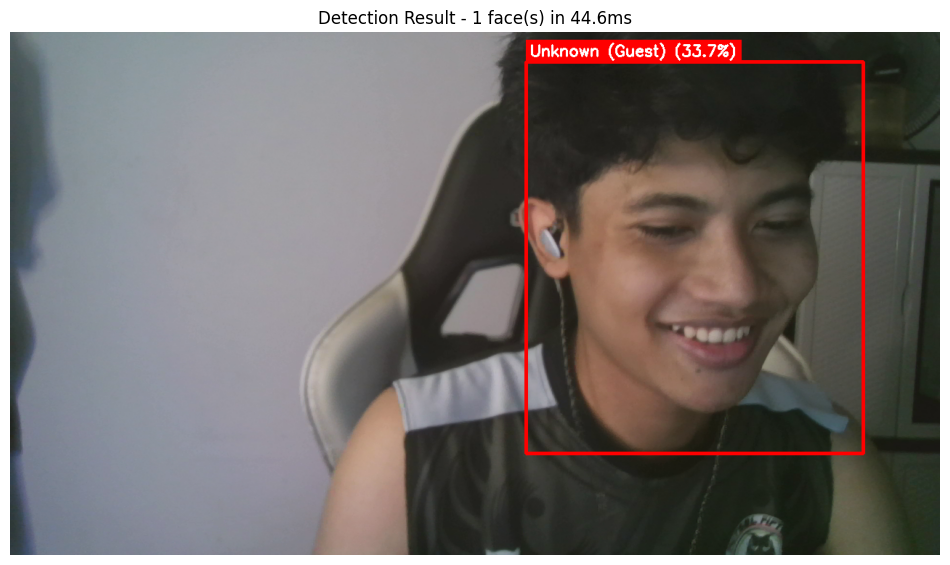

📸 Saved: inference_test.jpg


In [34]:
# ============================================================
# SINGLE IMAGE INFERENCE TEST
# ============================================================
# Test inference pada single image dari webcam

def capture_and_test():
    """
    Capture satu frame dari webcam dan test inference
    """
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("❌ Tidak bisa membuka webcam!")
        return
    
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    # Warm up camera
    for _ in range(10):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print("❌ Gagal capture frame!")
        return
    
    print("📸 Frame captured!")
    print("=" * 50)
    
    # Convert to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Run inference
    t_start = time.time()
    detections = detect_and_classify(rgb_frame)
    t_end = time.time()
    
    inference_time = (t_end - t_start) * 1000
    
    print(f"⏱️ Inference time: {inference_time:.1f} ms")
    print(f"👤 Faces detected: {len(detections)}")
    print()
    
    # Draw results
    for i, d in enumerate(detections):
        x1, y1, x2, y2 = d['bbox']
        color = (0, 255, 0) if d['authorized'] else (255, 0, 0)
        
        cv2.rectangle(rgb_frame, (x1, y1), (x2, y2), color, 3)
        
        label = f"{d['full_label']} ({d['confidence']*100:.1f}%)"
        
        # Background for text
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(rgb_frame, (x1, y1-30), (x1+tw+10, y1), color, -1)
        cv2.putText(rgb_frame, label, (x1+5, y1-8), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        
        # Print detection info
        status = "✅ AUTHORIZED" if d['authorized'] else "❌ UNAUTHORIZED"
        print(f"Face {i+1}:")
        print(f"   Name: {d['name']}")
        print(f"   Role: {d['role']}")
        print(f"   Confidence: {d['confidence']*100:.1f}%")
        print(f"   Status: {status}")
        print()
    
    # Display result
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_frame)
    plt.title(f"Detection Result - {len(detections)} face(s) in {inference_time:.1f}ms")
    plt.axis('off')
    plt.savefig('inference_test.jpg', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("📸 Saved: inference_test.jpg")

# Run single image test
capture_and_test()

---
# Part 8: Real-time Webcam
---

In [35]:
def run_webcam(duration=30):
    """Real-time webcam detection"""
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    if not cap.isOpened():
        print("❌ Could not open webcam")
        return
    
    print("🎥 Webcam started. Press 'q' to quit.")
    
    fps_list = []
    start_time = time.time()
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            t1 = time.time()
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            detections = detect_and_classify(rgb)
            fps = 1 / (time.time() - t1)
            fps_list.append(fps)
            
            # Draw
            for d in detections:
                x1, y1, x2, y2 = d['bbox']
                color = (0, 255, 0) if d['authorized'] else (0, 0, 255)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                label = f"{d['full_label']} ({d['confidence']*100:.1f}%)"
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            
            cv2.putText(frame, f"FPS: {np.mean(fps_list[-30:]):.1f}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow('YOLOv8 + ViT Face Recognition', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            if duration > 0 and (time.time() - start_time) > duration:
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print(f"\n📊 Average FPS: {np.mean(fps_list):.1f}")

# Run webcam
# run_webcam(30)

---
# Part 9: Save Configuration
---

In [36]:
# Save configuration
final_config = {
    "model": {
        "detector": "YOLOv8-face",
        "classifier": "ViT-base-patch16-224",
        "yolo_path": YOLO_MODEL_PATH,
        "vit_path": best_model_path
    },
    "classes": class_names,
    "role_mapping": ROLE_MAPPING,
    "thresholds": {
        "confidence": CONFIDENCE_THRESHOLD,
        "face_detection": 0.35
    },
    "training": CONFIG,
    "results": {
        "best_val_accuracy": best_val_acc,
        "final_train_loss": history['train_loss'][-1],
        "final_val_loss": history['val_loss'][-1]
    }
}

with open("model_config.json", "w") as f:
    json.dump(final_config, f, indent=2)

print("✅ Configuration saved to model_config.json")
print("\n📁 Output files:")
print(f"   - {best_model_path} (ViT weights)")
print(f"   - {YOLO_MODEL_PATH} (YOLOv8-face)")
print(f"   - model_config.json")
print(f"   - training_history.png")
print(f"   - confusion_matrix.png")

✅ Configuration saved to model_config.json

📁 Output files:
   - best_vit_yolo.pth (ViT weights)
   - yolov8-face.pt (YOLOv8-face)
   - model_config.json
   - training_history.png
   - confusion_matrix.png
